In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.connectivity.creation import get_connectivity_matrices3
#from mcmodels.core.utils import 
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)


annotation/ccf_2017


In [3]:
#load version 3 list
ontological_order = get_ordered_summary_structures(cache,167587189)
#due to redundancy in ccfv3, remove 'MDRNv', 'MDRNd' from summary structures (include as leafs of MDRN)
ontological_order[277]
ontological_order = np.setdiff1d(ontological_order, [1098, 1107])
#load version 2 list
#ontological_order = get_ordered_summary_structures(cache,687527945)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]

In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()


512
703
1089
1097
315
313
354
698
771
803
477
549


In [5]:
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [6]:
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)

In [7]:
above_thresh = {}
thresh = 1
for m in range(12):
    sid = major_structure_ids[m]
    above_thresh[sid] = np.where(connectivity_data.structure_datas[sid].reg_inj.sum(axis = 1) > thresh)[0]

In [8]:
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

frac_learn = np.ones(12)
frac_learn[4] = 1.
#sls = {}

In [9]:
#sid = 315
#connectivity_data.structure_datas[sid].reg_inj.sum(axis = 1)

In [10]:
#above_thresh

In [11]:
# fig, axes = plt.subplots(12,1,figsize = (5,30))
# for m in range(12):
#     sid = major_structure_ids[m]
#     axes[m].hist(np.log(connectivity_data.structure_datas[sid].reg_inj.sum(axis = 1)), bins=25)
#     axes[m].set_ylim(0,10)

In [12]:
summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
  
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [14]:
connectivity_data.structure_datas[315].reg_proj_injnorm.shape

(1102, 621)

In [13]:
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].reg_proj_injnorm = connectivity_data.structure_datas[sid].reg_proj_injnorm[above_thresh[sid]]
    connectivity_data.structure_datas[sid].centroids = connectivity_data.structure_datas[sid].centroids[above_thresh[sid]]
    connectivity_data.creline[sid] = connectivity_data.creline[sid][above_thresh[sid]]
    connectivity_data.summary_structures[sid] = connectivity_data.summary_structures[sid][above_thresh[sid]]

In [15]:
#from pygam import LinearGAM,PoissonGAM, te, s, f
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_injnorm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m])

0
1
2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/expectedloss/shapeconstrained.py:47: RuntimeWarning: invalid value encountered in true_divide
  coordinates_normed = coordinates / np.linalg.

3
4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


5
6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


7
8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


9
10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [16]:
from mcmodels.models.expectedloss.plotting import plot_loss_surface, plot_loss_scatter

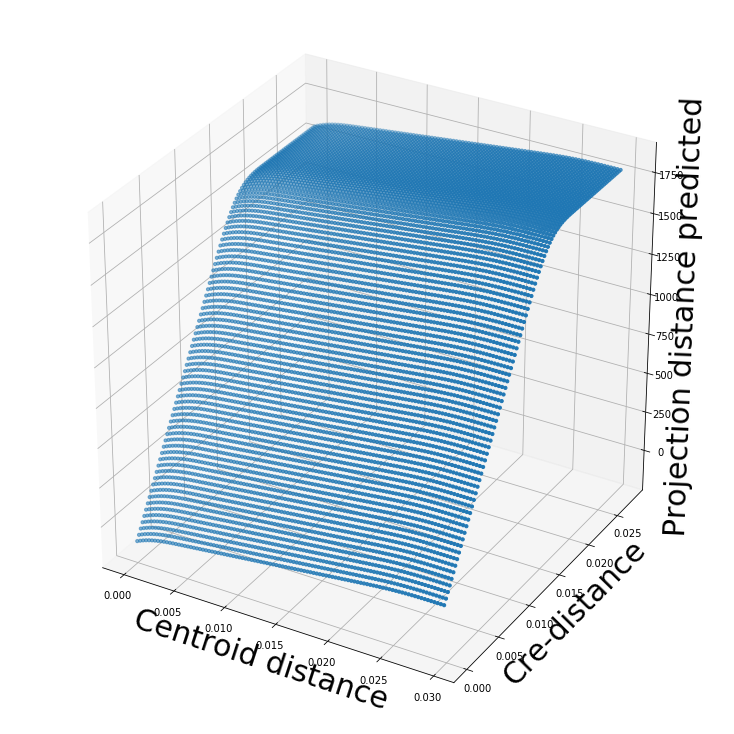

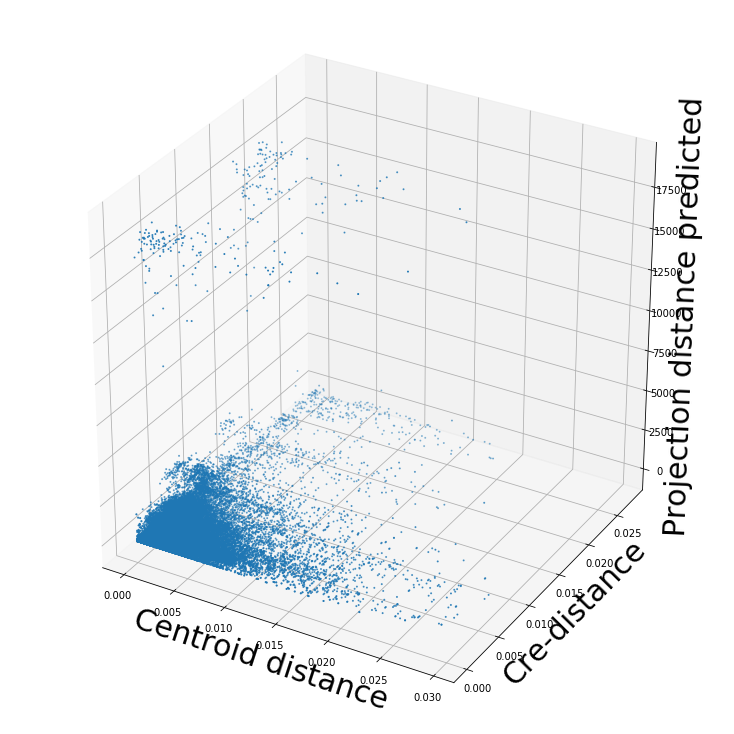

In [17]:
#there are some huge values for projection distance.... these are projections with a very small injection.
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)
plot_loss_scatter(connectivity_data.structure_datas[315].loss_surface_cv_str)

In [18]:
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv

In [19]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [21]:
class Crossval:
    
    def __init__(self):
        2+2
        
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists

In [24]:

connectivity_data.sum2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)



In [25]:
connectivity_data.sum2_index_matrices[315].shape

(42, 1102)

In [26]:
connectivity_data.get_cresum_combos()

In [27]:
connectivity_data.cresum2_index_matrices = get_indices_2ormore(connectivity_data.cresum_combos)
connectivity_data.cresum2_evalindices = get_eval_indices(connectivity_data.cresum2_index_matrices)

In [29]:
connectivity_data.structure_datas[315].reg_proj_injnorm.shape

(1102, 621)

In [30]:
twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_injnorm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_injnorm[sid ] = connectivity_data.structure_datas[sid].reg_proj_injnorm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_injnorm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.sum2_index_matrices[sid], 
                                                                                       connectivity_data.sum2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    


In [31]:
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions

twostage_leaf_creleaf2.losses = get_loss(reg_proj_injnorm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.cresum2_evalindices, true_ind = connectivity_data.cresum2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)


In [32]:
twostage_leaf_creleaf2.meanloss

array([0.48919654, 0.49739986, 0.31547795, 0.40858307, 0.38289521,
       0.32753877, 0.49411563, 0.38711131, 0.56212459, 0.44327197,
       0.29837563, 0.52753137])

In [33]:
#twostage_leaf_creleaf2 = Crossval()

pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    
#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
#reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    print(sid)
    #print(connectivity_data.structure_datas[sid].reg_proj_norm.shape)
    #reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    print('here')
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_injnorm[:,:], 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds[sid],                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.cresum2_index_matrices[sid], 
                                                                                       connectivity_data.cresum2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

512
here
703
here
1089
here


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:43: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


1097
here
315
here
313
here
354
here
698
here
771
here
803
here
477
here
549
here


In [34]:

# reg_proj_norm= {}
# for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
#     reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))
nw_creleaf_creleaf2 = Crossval()
nw_creleaf_creleaf2.loocvpredictions = loocvpredictions
nw_creleaf_creleaf2.losses = get_loss(reg_proj_injnorm, nw_creleaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.cresum2_evalindices, true_ind = connectivity_data.cresum2_evalindices,keys = keys)
nw_creleaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_creleaf_creleaf2.losses,keys)
nw_creleaf_creleaf2.meanloss = get_loss_best_hyp(nw_creleaf_creleaf2.losses, nw_creleaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

In [35]:
nw_creleaf_creleaf2.meanloss

array([0.70382722, 0.49739986, 0.31662777, 0.4297395 , 0.38652605,
       0.31469982, 0.67832154, 0.41229758, 0.56213315, 0.539072  ,
       0.3283235 , 0.71866839])

In [38]:
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/modelvalidation/predictions/crelines.pickle', 'rb') as handle:
    crelines = pickle.load(handle)
    
for sid in major_structure_ids:
    crelines[sid ] = crelines[sid][above_thresh[sid]]

In [39]:
#nw_losses_all = np.zeros((8,12))
nw_losses_all = np.zeros((8,12))
NWCreLeaf_meanlosses = {}
for g in range(8):
    for m in range(12):
        sid = major_structure_ids[m]
        leaf_sid = np.asarray([ia_map[summary_structures[sid][i]] for i in range(len(summary_structures[sid]))])[connectivity_data.cresum2_evalindices[sid]]
        comboloss = pd.DataFrame(np.asarray([nw_creleaf_creleaf2.losses[sid][[g],:][0], 
                     crelines[sid][connectivity_data.cresum2_evalindices[sid]],
                     leaf_sid]).transpose())
        
        comboloss.columns  = np.asarray(['NW-CreSum-Loss','Cre','Sum'])
#        comboloss['EL-Sum-Loss'] = pd.to_numeric(comboloss['EL-Sum-Loss'])
        comboloss['NW-CreSum-Loss'] = pd.to_numeric(comboloss['NW-CreSum-Loss'])


        NWCreLeaf_meanlosses[sid] = comboloss.pivot_table(
                values='NW-CreSum-Loss', 
                index='Cre', 
                columns='Sum', 
                aggfunc=np.mean)
        nw_losses_all[g,m] = np.nanmean(np.asarray(NWCreLeaf_meanlosses[sid]))
#        el_losses_all[g,m] = np.nanmean(np.asarray(ELLeaf_meanlosses[sid]))
        

In [41]:
np.min(nw_losses_all, axis = 0)

array([0.70382722, 0.49739986, 0.33104172, 0.41457338, 0.42642258,
       0.35694321, 0.62144926, 0.49417978, 0.56213315, 0.51920372,
       0.35967607, 0.82472954])

In [42]:
#nw_losses_all = np.zeros((8,12))
el_losses_all = np.zeros((8,12))
ELLeaf_meanlosses = {}
for g in range(8):
    for m in range(12):
        sid = major_structure_ids[m]
        leaf_sid = np.asarray([ia_map[summary_structures[sid][i]] for i in range(len(summary_structures[sid]))])[connectivity_data.cresum2_evalindices[sid]]
        comboloss = pd.DataFrame(np.asarray([twostage_leaf_creleaf2.losses[sid][[g],:][0], 
                     crelines[sid][connectivity_data.cresum2_evalindices[sid]],
                     leaf_sid]).transpose())
        comboloss.columns  = np.asarray(['EL-Sum-Loss','Cre','Sum'])
        comboloss['EL-Sum-Loss'] = pd.to_numeric(comboloss['EL-Sum-Loss'])
#        comboloss['NW-CreSum-Loss'] = pd.to_numeric(comboloss['NW-CreSum-Loss'])

        ELLeaf_meanlosses[sid] = comboloss.pivot_table(
                values='EL-Sum-Loss', 
                index='Cre', 
                columns='Sum', 
                aggfunc=np.mean)

#         NWCreLeaf_meanlosses[sid] = comboloss.pivot_table(
#                 values='NW-CreSum-Loss', 
#                 index='Cre', 
#                 columns='Sum', 
#                 aggfunc=np.mean)
#        nw_losses_all[g,m] = np.nanmean(np.asarray(NWCreLeaf_meanlosses[sid]))
        el_losses_all[g,m] = np.nanmean(np.asarray(ELLeaf_meanlosses[sid]))
        

In [43]:
np.min(el_losses_all, axis = 0)

array([0.48919654, 0.49739986, 0.32325392, 0.3991872 , 0.4081778 ,
       0.35972776, 0.43905425, 0.4370605 , 0.56212459, 0.43435694,
       0.32288284, 0.5926408 ])